# Model Pipelines
- Attempting to beat the benchmark test accuracy (77.7%) from default Logistic Regression from [simple_models.ipynb](./simple_models.ipynb).

## Vision for the final model:
- __NOTE__: "Dysfunctional" well refers to either a "needs repair" or "non-functional" well.
- Overall accuracy is important, but identifying dysfunctional wells should also be a priority.
- The cost of misidentifying a functional well is extra money spent. The cost of misidentifying a dysfunctional is much greater: human health and potentially human lives.
- Therefore, want to maximize __recall__ (class-specific accuracy) for the dysfunctional wells (classes 1 and 2).

# Load in data:

In [1]:
# import dependencies

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# import cleaned data from cleaning.ipynb
df = pd.read_csv('data/features_cleaned.csv', index_col='Unnamed: 0').drop('id', axis=1)

In [3]:
# create features and target
X = df.drop('status_group', axis=1)
y = df.status_group

# encode y into labels [0, 1, 2]
le = LabelEncoder()

# 3-label multiclass targets
y_encoded = le.fit_transform(y)

# 3-label target
set(y_encoded)

{0, 1, 2}

In [4]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=0)

# Create sub-pipelines:

In [5]:
# get numeric and object columns
num_cols = []
cat_cols = []

for col in X.columns:
    if np.issubdtype(X[col].dtype, np.number):
        num_cols.append(col)
    else:
        cat_cols.append(col)

In [6]:
# create numeric and categorical subpipes for different column types
num_pipe = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean', add_indicator=True)),
    ('ss', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

In [7]:
# transform the columns

ct = ColumnTransformer(transformers=[
    
    ('nums', num_pipe, num_cols),
    ('cats', cat_pipe, cat_cols)
    
], remainder='passthrough', n_jobs=-1)

# First optimized model:
- Using the most consistent hyperparameters found from __model_pipeline_21_feats.ipynb__.

In [8]:
# no regularization

model_base = Pipeline([
    ('ct', ct),
    ('model_base', LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty=None, n_jobs=-1))
])

model_base.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'region_code',
                                                   'district_code',
                                                   'population', 'age_years']),
                                                 ('cats',
                                                  Pipeline(steps=[('cat_impute',
                                                                   Simp...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'public_meeting',
                                                   'scheme_name', 'permit',
                                                   'extraction_type',
                                                   'extraction_type_class',
                                                   'management', 'payment',
                                                   'water_quality', 'quantity',
                                                   'source', 'source_class',
                                                   'waterpoint_type'])])),
                ('model_base',
                 LogisticRegression(multi_class='multinomial', n_jobs=-1,
                                    penalty=None, solver='newton-cg'))])

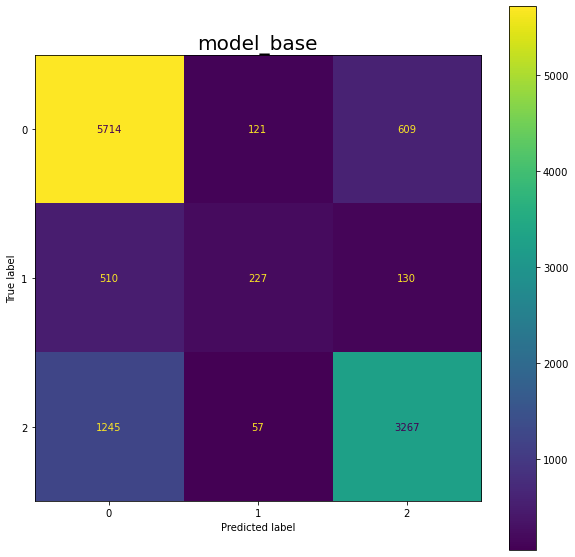

In [9]:
# display the confision matrix
fig, ax = plt.subplots(figsize=(10,10))
plt.title('model_base', fontsize=20)

ConfusionMatrixDisplay.from_estimator(model_base, X_test, y_test, ax=ax);

In [10]:
# accuracy scores
model_base.score(X_train, y_train), model_base.score(X_test, y_test)

(0.798526936026936, 0.775084175084175)

- 79.9% training acc, 77.5% testing acc. Slightly worse than benchmark (-0.2%)
- The 2.4% higher train accuracy may indicate overfitting. This makes sense, as we used no regularization for this model.

In [11]:
# analyze f1 scores
print(classification_report(y_test, model_base.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82      6444
           1       0.56      0.26      0.36       867
           2       0.82      0.72      0.76      4569

    accuracy                           0.78     11880
   macro avg       0.71      0.62      0.65     11880
weighted avg       0.77      0.78      0.76     11880



- f1 scores for class 0 and class 2 are impressive: 0.82 and 0.76 respectively.
- f1 for class 1 is quite poor (0.36). May try the class_weight parameter or reincorporate SMOTE.

#  Dysfunctional accuracy:
- Create a function that calculates a model's accuracy at predicting dysfunctional wells.
- Create a function that returns a df that contains model parameters, test_score, and dysfunctional accuracies for a group of models.

In [12]:
def calc_dys(model, X_test, y_test):
    # get predictions
    preds = model.predict(X_test)
        
    # 3-class (multi)
    if len(np.bincount(y_test)) == 3:
        
        # total times class 1 predictions were correct
        correct_1 = ((preds == y_test) & (preds == 1)).sum()

        # class 1 accuracy
        acc_1 = correct_1 / np.bincount(y_test)[1]


        # total times class 2 predictions were correct
        correct_2 = ((preds == y_test) & (preds == 2)).sum()

        # class 2 accuracy
        acc_2 = correct_2 / np.bincount(y_test)[2]


        # 'dysfunctional' accuracy - the total acc of our model on classes 1 and 2
        dys_acc = (correct_1 + correct_2) / (np.bincount(y_test)[1] +np.bincount(y_test)[2])

        # return dysfunctional acc
        return dys_acc
    
    # 2-class (binary)
    else:
        # total times class 1 predictions were correct
        correct_1 = ((preds == y_test) & (preds == 1)).sum()

        # class 1 accuracy
        acc_1 = correct_1 / np.bincount(y_test)[1]

        # return class 1 acc
        return acc_1

In [14]:
# test calc_dys on model_base
dys_acc = calc_dys(model_base, X_test, y_test)

print(f'Dysfunctional accuracy: {dys_acc*100:.2f}%')

Dysfunctional accuracy: 64.28%


- The dysfunctional accuracy of our model is 64%.

In [15]:
def get_df(grid_search, model_name):
    
    '''
    
    Looks at the top 10% of mean_test_scores from the grid_search argument. Calculates dysfunctional accuracy for these values 
    and returns a 3-column dataframe.
    
    
    Parameters
    ---------------
    grid_search : GridSearchCV, fitted GridSearchCV object.
    model_name: str, the name of the model from the grid search.
    
    
    Returns
    ---------------
    models_df : pandas.DataFrame, holds model parameters, test_score, and dysfunctional accuracy.
    
    
    
    '''
    
    # get results of grid search into df, drop most columns
    df = pd.DataFrame.from_dict(grid_search.cv_results_).drop(
        ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'split0_test_score', 'split1_test_score', 
         'split2_test_score', 'split3_test_score', 'split4_test_score', 'rank_test_score', 'std_test_score'], axis=1)
    
    # num rows in top 10% of df, the +1 rounds up to a whole number
    num_rows = (len(df) // 10) + 1
    
    # new df holding top 10% of test_scores from df
    top_10_percent = df.sort_values('mean_test_score', ascending=False).iloc[:num_rows]
    
    # acc of the final row. the minimum model accuracy that will be included in the returned dataframe
    threshold = top_10_percent.iloc[[-1]]['mean_test_score'].values[0]
    
    # models with test acc above threshold
    top_models = df[df['mean_test_score'] > threshold]

    # create default pipeline object for below loop
    pipeline = Pipeline([
        ('ct', ct),
        (model_name, LogisticRegression(n_jobs=-1))
    ])



    # get list of model parameters from top_models
    params_list = top_models.params.tolist()

    # get list of model test_scores from top_models
    scores_list = top_models.mean_test_score.tolist()

    # to store dysfunctional accuracies
    dys_accs = []

    for params in params_list:
        # Set parameters of the pipeline, fit
        pipeline.set_params(**params)  
        pipeline.fit(X_train, y_train)

        # calculate dys_acc
        dys_acc = calc_dys(pipeline, X_test, y_test)
        dys_accs.append(dys_acc)


    data_dict = {
        'params': params_list,
        'test_score': scores_list,
        'dys_acc': dys_accs
    }    

    # create a models_df to hold the important results
    models_df = pd.DataFrame(data=data_dict)
    
    return models_df

# Grid search 1:

In [16]:
# only parameter passed is 'multinomial'

model_1 = Pipeline([
    ('ct', ct),
    ('model_1', LogisticRegression(multi_class='multinomial', n_jobs=-1))
])

model_1.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'region_code',
                                                   'district_code',
                                                   'population', 'age_years']),
                                                 ('cats',
                                                  Pipeline(steps=[('cat_impute',
                                                                   Simp...
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'public_meeting',
                                                   'scheme_name', 'permit',
                                                   'extraction_type',
                                                   'extraction_type_class',
                                                   'management', 'payment',
                                                   'water_quality', 'quantity',
                                                   'source', 'source_class',
                                                   'waterpoint_type'])])),
                ('model_1',
                 LogisticRegression(multi_class='multinomial', n_jobs=-1))])

In [17]:
# accuracy scores before grid search
model_1.score(X_train, y_train), model_1.score(X_test, y_test)

(0.7829335016835017, 0.7721380471380471)

- 77.2% accuracy - slightly worse than model_base (-0.3%).

In [18]:
# get dysfunctional accuracy
dys_acc = calc_dys(model_1, X_test, y_test)

print(f'Dysfunctional accuracy: {dys_acc*100:.2f}%')

Dysfunctional accuracy: 63.54%


- 63.5% dysfunctional accuracy - also slightly worse than model_base (-0.7%).
- Overall, a slightly worse model than model_base.

In [266]:
# large grid search (no SMOTE)
# 216 unique models

params = {
    'ct__nums__num_impute__strategy': ['mean', 'median'],
    'model_1__class_weight': [None, {0: 1, 1: 1.5, 2: 1}, {0: 1, 1: 2, 2: 1}],
    'model_1__penalty': ['l2'],
    'model_1__solver' : ['lbfgs', 'newton-cg', 'sag'],
    'model_1__max_iter': [100, 1000],
    'model_1__C' : [1e2, 1e3, 1e4],
    'model_1__tol' : [0.001, 0.01]
}

search_1 = GridSearchCV(model_1, params, n_jobs=-1, verbose=2)

In [267]:
# DO NOT RUN THIS CELL

# perform grid search
search_1.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('nums',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(add_indicator=True)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'longitude',
                                                                          'latitude',
                                                                          'num_private',
                                                                          'region_code',
                                                                          'district_code',
                                                                          'population',
                                                                          'age_years']),
                                                                        ('cats',
                                                                         Pipeline(st...
                                        LogisticRegression(multi_class='multinomial',
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'ct__nums__num_impute__strategy': ['mean', 'median'],
                         'model_1__C': [1, 100.0, 1000.0, 10000.0],
                         'model_1__class_weight': [None, {0: 1, 1: 1.5, 2: 1},
                                                   {0: 1, 1: 2, 2: 1}],
                         'model_1__max_iter': [100, 1000],
                         'model_1__penalty': ['l2'],
                         'model_1__solver': ['lbfgs', 'newton-cg', 'sag'],
                         'model_1__tol': [0.001, 0.01]},
             verbose=2)

In [ ]:
# use get_df for multiclass grid search 1
multi_df_1 = get_df(grid_search=search_1, model_name='model_1')
multi_df_1['smote'] = 0

# top 10 dys_accs
multi_df_1.sort_values('dys_acc', ascending=False).head(10)

# Analyze search_1 hyperparameters:

# SMOTE:

In [269]:
model_2 = Pipeline([
    ('ct', ct),
    ('smote', SMOTE()),
    ('model_2', LogisticRegression(multi_class='multinomial', n_jobs=-1))
])

model_2.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'region_code',
                                                   'district_code',
                                                   'population', 'age_years']),
                                                 ('cats',
                                                  Pipeline(steps=[...
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'public_meeting',
                                                   'scheme_name', 'permit',
                                                   'extraction_type',
                                                   'extraction_type_class',
                                                   'management', 'payment',
                                                   'water_quality', 'quantity',
                                                   'source', 'source_class',
                                                   'waterpoint_type'])])),
                ('smote', SMOTE()),
                ('model_2',
                 LogisticRegression(multi_class='multinomial', n_jobs=-1))])

In [270]:
# large grid search 2 (with SMOTE)

params = {
    'ct__nums__num_impute__strategy': ['mean', 'median'],
    'smote__sampling_strategy': ['auto', {1: 0.3, 2: 1}, {1: 0.5,2: 1}], 
    'model_2__class_weight': [None, {0: 1, 1: 1.33, 2: 1}, {0: 1, 1: 1.67, 2: 1}, {0: 1, 1: 2, 2: 1}],
    'model_2__penalty': ['l1', 'l2'],
    'model_2__solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'model_2__max_iter': [100],
    'model_2__C' : [1, 1e2, 1e3, 1e4, 1e5],
    'model_2__tol' : [0.0001, 0.001, 0.01]
}

search_2 = GridSearchCV(model_2, params, n_jobs=-1)

In [ ]:
# DO NOT RUN THIS CELL

search_2.fit(X_train, y_train)

In [ ]:
# use get_df for multiclass grid search 2
multi_df_2 = get_df(grid_search=search_2, model_name='model_2')
multi_df_2['smote'] = 1

# top 10 dys_accs
multi_df_2.sort_values('dys_acc', ascending=False).head(10)

# Analyze best multi-class models:

In [ ]:
# combine the two dataframes
multi_df = pd.concat([multi_df_1, multi_df_2])

# top 10 dys_accs
multi_df.sort_values('dys_acc', ascending=False).head(10)

# Binary classification:
- Turning this problem from ternary -> binary to see if we can predict dysfunctional wells more accurately.

### Ternary classification:
- This is the type of multi-class classification we have used thus far.
- "functional" is class 0.
- "functional needs repair" is class 1.
- "non functional" is class 2.

### Binary classification:
- "functional" is class 0
- "functional needs repair" and "non functional" are class 1

In [ ]:
# combining 'functional needs repair' and 'non functional' to get a 2-label binary target
y_2_labels = y_encoded.copy()
y_2_labels[y_2_labels == 2] = 1

# 2-label target
set(y_2_labels)

In [ ]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_2_labels, test_size=0.2, random_state=0)

In [20]:
# using default parameters

binary_base = Pipeline([
    ('ct', ct),
    ('binary_base', LogisticRegression(n_jobs=-1))
])

binary_base.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'region_code',
                                                   'district_code',
                                                   'population', 'age_years']),
                                                 ('cats',
                                                  Pipeline(steps=[('cat_impute',
                                                                   Simp...indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'public_meeting',
                                                   'scheme_name', 'permit',
                                                   'extraction_type',
                                                   'extraction_type_class',
                                                   'management', 'payment',
                                                   'water_quality', 'quantity',
                                                   'source', 'source_class',
                                                   'waterpoint_type'])])),
                ('binary_1', LogisticRegression(n_jobs=-1))])

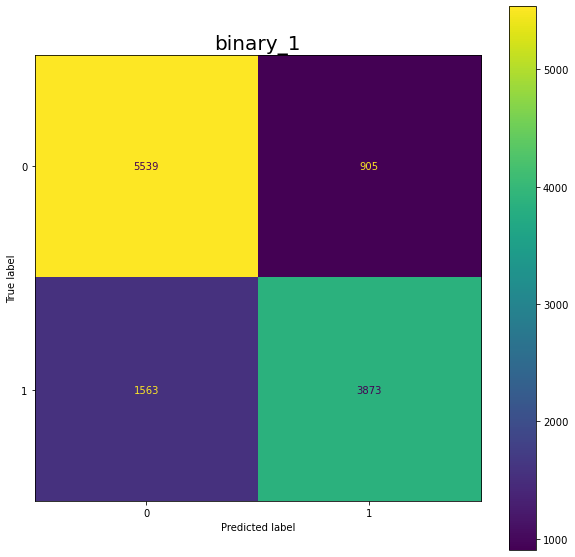

In [21]:
# display the confision matrix
fig, ax = plt.subplots(figsize=(10,10))
plt.title('binary_base', fontsize=20)

ConfusionMatrixDisplay.from_estimator(binary_base, X_test, y_test, ax=ax);

In [22]:
# accuracy scores
binary_base.score(X_train, y_train), binary_base.score(X_test, y_test)

(0.803493265993266, 0.7922558922558922)

- 80.3% training acc, 79.2% testing acc.
- Already on default binary model, we have acheived a nice test score.

In [23]:
# analyze f1 scores
print(classification_report(y_test, binary_base.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      6444
           1       0.81      0.71      0.76      5436

    accuracy                           0.79     11880
   macro avg       0.80      0.79      0.79     11880
weighted avg       0.79      0.79      0.79     11880



- "Positives" (class 1) are __dysfunctional__ wells.
- "Negatives" (class 0) are __functional__ wells.
- We want to maximize accuracy for dysfunctional wells, meaning we want to minimize false negatives. This means we want to __maximize recall__ for class 1.
- Recall for class 1 is 0.71, and we want to get that up.

In [101]:
# calculate dysfunctional accuracy
calc_dys(binary_base, X_test, y_test)

0.7124724061810155

- calc_dys returns the same value as the recall from class 1.

## Binary search 1

In [ ]:
# using default parameters

binary_1 = Pipeline([
    ('ct', ct),
    ('binary_1', LogisticRegression(n_jobs=-1))
])

binary_1.fit(X_train, y_train)

In [ ]:
# first binary grid search, 120 unique models

params = {
    'ct__nums__num_impute__strategy': ['mean', 'median'],
    'binary_1__class_weight': [None, {0: 1, 1: 1.5}, {0: 1, 1: 2}],
    'binary_1__penalty': ['l2'],
    'binary_1__solver' : ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'binary_1__max_iter': [100],
    'binary_1__C' : [1e-1, 1, 1e2, 1e3],
    'binary_1__tol' : [0.001]
}

binary_search_1 = GridSearchCV(binary_1, params, n_jobs=-1, verbose=2)

In [ ]:
# DO NOT RUN THIS CELL

# perform grid search
binary_search_1.fit(X_train, y_train)

In [ ]:
# get best estimator
best_search_1 = binary_search_1.best_estimator_

# accuracy scores
best_search_1.score(X_train, y_train), best_search_1.score(X_test, y_test)

- Training acc higher than binary_base, but test acc lower. This means the model is overfitting (may need more regularization).

In [276]:
binary_search_1.best_params_

{'binary_2__C': 100.0,
 'binary_2__class_weight': None,
 'binary_2__max_iter': 100,
 'binary_2__penalty': 'l2',
 'binary_2__solver': 'liblinear',
 'binary_2__tol': 0.001,
 'ct__nums__num_impute__strategy': 'median'}

In [ ]:
# use get_df for binary grid search 1
binary_df_1 = get_df(grid_search=binary_search_1, model_name='binary_2')

In [ ]:
# top 10 dys_accs
binary_df_1.sort_values('dys_acc', ascending=False).head(10)

- No major differences. Top two models seem the best.

## Analyze binary search 1 hyperparameters:

### Impute strategy:

In [98]:
# look at mean and median test scores for all impute strategies
binary_search_1_df.groupby(['param_ct__nums__num_impute__strategy']).mean().merge(binary_search_1_df.groupby(['param_ct__nums__num_impute__strategy']).median(), on='param_ct__nums__num_impute__strategy')

,mean_test_score_x,mean_test_score_y
param_ct__nums__num_impute__strategy,,
mean,0.767151,0.767172
median,0.767131,0.767277


- No real difference. I will use both in binary_search_2.

### Class weight:

In [104]:
# convert class weights from dict -> str
binary_search_1_df['param_binary_1__class_weight'] = binary_search_1_df['param_binary_1__class_weight'].astype(str)

# look at mean and median test scores for all class weight values
binary_search_1_df.groupby(['param_binary_1__class_weight']).mean().merge(binary_search_1_df.groupby(['param_binary_1__class_weight']).median(), on='param_binary_1__class_weight')

,mean_test_score_x,mean_test_score_y
param_binary_2__class_weight,,
nan,0.781428,0.780766
"{0: 1, 1: 1.5}",0.770396,0.769402
"{0: 1, 1: 2}",0.749599,0.746517


- No class weight performed the best.

### Solver:

In [105]:
# look at mean and median test scores for all solvers
binary_search_1_df.groupby(['param_binary_1__solver']).mean().merge(binary_search_1_df.groupby(['param_binary_1__solver']).median(), on='param_binary_1__solver')

,mean_test_score_x,mean_test_score_y
param_binary_2__solver,,
lbfgs,0.770979,0.773716
liblinear,0.775630,0.780577
newton-cg,0.775628,0.780492
sag,0.758865,0.762774
saga,0.754602,0.760911


- 'liblinear' and 'newton-cg' performed the best. Also going to incorporate 'newton-cholesky' in next search.
- 'sag' and 'saga' performed poorly.

### C:

In [42]:
# look at mean and median test scores for all C values
binary_search_1_df.groupby(['param_binary_2__C']).mean().merge(binary_search_1_df.groupby(['param_binary_2__C']).median(), on='param_binary_2__C')

,mean_test_score_x,mean_test_score_y
param_binary_2__C,,
0.1,0.761664,0.766067
1.0,0.768883,0.767224
100.0,0.769184,0.767266
1000.0,0.768832,0.767256


- Higher C values above 0.1 (less regularization) had better mean and median scores.

## Binary search 2

In [273]:
# using default parameters

binary_2 = Pipeline([
    ('ct', ct),
    ('binary_2', LogisticRegression(n_jobs=-1))
])

binary_2.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'region_code',
                                                   'district_code',
                                                   'population', 'age_years']),
                                                 ('cats',
                                                  Pipeline(steps=[...
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'public_meeting',
                                                   'scheme_name', 'permit',
                                                   'extraction_type',
                                                   'extraction_type_class',
                                                   'management', 'payment',
                                                   'water_quality', 'quantity',
                                                   'source', 'source_class',
                                                   'waterpoint_type'])])),
                ('binary_2', LogisticRegression(n_jobs=-1))])

In [274]:
# using parameters found from above analysis
# second binary grid search, 240 unique models

params = {
    'ct__nums__num_impute__strategy': ['mean', 'median'],
    'binary_2__class_weight': [None],
    'binary_2__penalty': ['l1', 'l2'],
    'binary_2__solver' : ['liblinear', 'newton-cg', 'newton-cholesky'],
    'binary_2__max_iter': [100, 1000],
    'binary_2__C' : [1, 1e2, 1e3, 1e4, 1e5],
    'binary_2__tol' : [0.0001, 0.001]
}

binary_search_2 = GridSearchCV(binary_2, params, n_jobs=-1, verbose=2)

In [275]:
# DO NOT RUN THIS CELL

# perform grid search
binary_search_2.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


KeyboardInterrupt: 

In [ ]:
# use get_df for binaryclass grid search 2
binary_df_2 = get_df(grid_search=binary_search_2, model_name='binary_2')

# top 10 dys_accs
binary_df_2.sort_values('dys_acc', ascending=False).head(10)

# Analyze best binary models:

In [ ]:
# combine the two dataframes
binary_df = pd.concat([binary_df_1, binary_df_2])

# top 10 dys_accs
binary_df.sort_values('dys_acc', ascending=False).head(10)